In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [2]:
# You can work with the dataset being dowloaded only ONCE!! It seems like transforms.Resize won't overwrite
# the original dataset!!
size = 28
train_data = datasets.MNIST(
    root = '../data/28x28',
    train = True,                         
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(size),
                    transforms.Normalize(0, 1)
                ]), 
    download = False,            
)
test_data = datasets.MNIST(
    root = '../data/28x28', 
    train = False, 
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(size),
                    transforms.Normalize(0, 1)
                ]) 
)

/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1631631159818/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# train_data[0][0].shape

<h3>MNIST Dataset is organized by:</h3>
<div>Set of images (with channels) and labels --> train_data</div>
<div>image (with channels) AND label --> train_data[i (0,59999)]</div>
<div>image (with channels) --> train_data[i][i (0,1)]</div>
<div>image by itself (2D image) --> train_data[i][i][i (0)]</div>

In [4]:
# Images and labels are stored as a tuple (image, label)

# print(len(train_data[0]), '\n\n')
# print(train_data[0])

In [5]:
# train_data[0]

In [6]:
# train_data[0][0]

In [7]:
# Prints the entire dataset
# train_data[0][0].shape

In [8]:
# Prints one image
# train_data[0][0][0]

In [9]:
# Prints one array of pixels (not the entire image)
# train_data[0][0][0][0]

In [10]:
# plt.imshow(train_data[1][0][0])

In [11]:
# transforms.Resize(size=14)(train_data.data)

In [12]:
# type(train_data)

In [13]:
# plt.imshow(train_data.train_data[0])

In [14]:
# Resize(size[, interpolation, max_size, …])

In [15]:
# resized = transforms.Resize(size=14)(train_data.train_data)
# plt.imshow(resized[0])

In [16]:
# type(resized)

In [17]:
resized_28 = transforms.Resize(size=28)(train_data.train_data)
resized_14 = transforms.Resize(size=14)(train_data.train_data)
resized_7 = transforms.Resize(size=7)(train_data.train_data)
resized_4 = transforms.Resize(size=4)(train_data.train_data)

/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


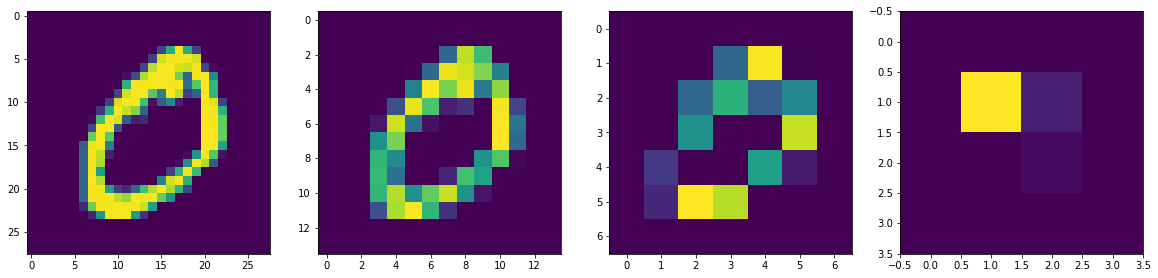

In [18]:
index = 1
f, axarr = plt.subplots(1,4, figsize=(20,5))
axarr[0].imshow(resized_28[index])
axarr[1].imshow(resized_14[index])
axarr[2].imshow(resized_7[index])
axarr[3].imshow(resized_4[index])

<h1>Using Pytorch's Data loaders to feed data into CNN</h1>

In [17]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f829981dc88>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f82956b1400>}

<h1>Defining the CNN</h1>

In [18]:
class CNN(nn.Module):
    def __init__(self, img_shape = 28, conv_layers = 2, num_classes = 10):
        super(CNN, self).__init__()
        
#         self.conv_count = 0   #keeps track of the number of times a conv layer is added
        self.img_shape = img_shape   
        self.num_classes = num_classes
        self.conv_layers = conv_layers
        self.root_path = '../data/28x28'
        self.ker_size = 0
        self.padding = 0
        self.out_channels = 0
        self.linear_shape = [1, img_shape, img_shape]
        self.conv = []
        
        
        def conv_out_size(linear_shape, img_shape, conv):
            linear_shape[0] = conv[0].out_channels
            linear_shape[1] = int(( (img_shape - conv[0].kernel_size[0] + 2*conv[0].padding[0]) / conv[0].stride[0]) + 1)
            img_shape = linear_shape[1]
            linear_shape[2] = linear_shape[1]

            return linear_shape, img_shape


        def pooling_out_size(linear_shape, img_shape, conv):
            linear_shape[1] = int(( (img_shape - conv[2].kernel_size) / conv[2].stride) + 1)
            img_shape = linear_shape[1]
            linear_shape[2] = linear_shape[1]

            return linear_shape, img_shape

        def flatten(linear_shape):
            return linear_shape[0] * linear_shape[1] * linear_shape[2]
        
        
        def load_data(img_shape, root_path):
            train_data = datasets.MNIST(
                root = root_path,
                train = True,                         
                transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(img_shape),
                                transforms.Normalize(0, 1)
                            ]), 
                download = False,            
            )
            test_data = datasets.MNIST(
                root = '../data/28x28', 
                train = False, 
                transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(img_shape),
                                transforms.Normalize(0, 1)
                            ]) 
            )
            
            return train_data, test_data
        
        
        # Loading training and testing data
#         self.train_data, self.test_data = load_data(self.img_shape, self.root_path)
        
#         self.loaders = {
#             'train' : torch.utils.data.DataLoader(self.train_data, 
#                                                   batch_size=100, 
#                                                   shuffle=True, 
#                                                   num_workers=1),

#             'test'  : torch.utils.data.DataLoader(self.test_data, 
#                                                   batch_size=100, 
#                                                   shuffle=True, 
#                                                   num_workers=1),
#         }
        
        if self.img_shape == 28:
            self.out_channels = 16
            self.ker_size = 5
        
        elif self.img_shape == 14:
            self.out_channels = 8
            self.ker_size = 3
            
        elif self.img_shape == 7:
            self.out_channels = 4
            self.ker_size = 2
            
        elif self.img_shape == 4:
            self.out_channels = 4
            self.ker_size = 3
            self.padding = 1
        
        for i in range(conv_layers):
#             ker_size = 5
#             padding = 0
            if not self.conv:
                layer = nn.Sequential(         
                    nn.Conv2d(
                        in_channels=1,              
                        out_channels=self.out_channels,            
                        kernel_size=self.ker_size,              
                        stride=1,                   
                        padding=self.padding,                  
                    ),                              
                    nn.ReLU(),                      
                    nn.MaxPool2d(kernel_size=2),    
                )
                
            else:
                layer = nn.Sequential(         
                    nn.Conv2d(
                        in_channels = self.conv[i-1][0].out_channels,              
                        out_channels = self.conv[i-1][0].out_channels * 2,            
                        kernel_size = self.ker_size,              
                        stride = 1,                   
                        padding=self.padding,                  
                    ),                              
                    nn.ReLU(),                      
                    nn.MaxPool2d(kernel_size=2),    
                )
            
            self.conv.append(layer)
#             self.conv_count += 1
            
            self.linear_shape, self.img_shape = conv_out_size(self.linear_shape, self.img_shape, self.conv[i])
            self.linear_shape, self.img_shape = pooling_out_size(self.linear_shape, self.img_shape, self.conv[i])
            
#             if self.img_shape <= 0 and self.ker_size >= 2:
#                 self.ker_size -= 1
#                 i = -1
#                 self.img_shape = img_shape
#                 print("executed!!")
            
#             print("ker_size = ", self.ker_size)
            
#             elif img_shape == 0 and padding == 0:
#                 padding += 1
#                 i = -1
#                 self.img_shape = img_shape
#                 print(img_shape)
            
            continue
        
        # input to Linear layer MUST be an integer!!
        self.out_shape = int(flatten(self.linear_shape))
        self.out = nn.Linear(self.out_shape, self.num_classes)
        
        
        
        
        
    def forward(self, x):
        for i in range(len(self.conv)):
            x = self.conv[i](x)
            
        # flatten the output of conv2 to (batch_size, 32 * 4 * 4)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization
    
    

In [19]:
cnn = CNN(28)
cnn

CNN(
  (out): Linear(in_features=512, out_features=10, bias=True)
)

In [20]:
cnn.out_shape

512

In [21]:
32*4*4

512

In [24]:
# layer = nn.Sequential(         
#                     nn.Conv2d(
#                         in_channels=1,              
#                         out_channels=16,            
#                         kernel_size=5,              
#                         stride=1,                   
#                         padding=0,                  
#                     ),                              
#                     nn.ReLU(),                      
#                     nn.MaxPool2d(kernel_size=2),    
#         )

In [25]:
# def sum(x, y):
#     return x+y, x-y

# a, b = sum(2, 5)
# print("a = ", a)
# print("b = ", b)

In [26]:
# layer

In [27]:
# layer[2].stride

In [28]:
# '''
#         Goes through two layers of 2D convolutions, each followed by a 2x2 max pooling
        
#         Dimensions:
#         1.) Input Shape:          [batch_size, 1, 28, 28]
        
#         2.) After conv:           [batch_size, 16, 24, 24]
#             After max pooling:    [batch_size, 32, 12, 12]
        
#         3.) After conv:           [batch_size, 16, 12, 12]
#             After max pooling:    [batch_size, 32, 4, 4]
            
#         4.) After flattening:     [batch_size, 32 * 4 * 4]
#         '''

# img_shape = 28
# in_channels = [1, 16]
# out_channels = [16, 32]
# conv_ker_size = 5
# pool_ker_size = 2
# linear = [1, img_shape, img_shape]

# def conv_out_size(linear, img_shape, conv_ker_size):
#     linear[0] = out_channels[]
#     linear[1] = ( (img_shape - conv_ker_size + 2*padding) / stride) + 1
#     linear[2] = linear[1]
    
#     return 

# def pooling_out_size(in_shape):
#     return ( (in_shape[1] - pool_ker_size) / stride) + 1

In [29]:
# cnn = CNN(28)
# print(cnn)

In [22]:
loss_func = nn.CrossEntropyLoss(); print(loss_func)   
optimizer = torch.optim.Adam(cnn.parameters(), lr= 1e-5); print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)


<h1>Training the CNN</h1>
<div>Error source may be that the dataset resized_28 doesn't have 'labels', just 'images' ---> (for i, (images, labels))</div>

In [23]:
def train(num_epochs, cnn, loaders):
    
    cnn.train()
    
    train_acc_data = []
    loss_data = []
    # Train the model
    total_step = len(loaders['train'])    
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # measure accuracy and record loss
            train_output, last_layer = cnn(images)
            pred_y = torch.max(train_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), accuracy))
                
            if (i+1) % 600 == 0:
                train_acc_data.append(accuracy)
                loss_data.append(loss)
            pass
        
        pass
    
    
    pass



In [24]:
%%time
num_epochs = 2
train(num_epochs, cnn, loaders)

Epoch [1/2], Step [100/600], Loss: 2.3024, Accuracy: 0.1500
Epoch [1/2], Step [200/600], Loss: 2.2906, Accuracy: 0.1200
Epoch [1/2], Step [300/600], Loss: 2.2817, Accuracy: 0.1600
Epoch [1/2], Step [400/600], Loss: 2.2805, Accuracy: 0.1700
Epoch [1/2], Step [500/600], Loss: 2.2704, Accuracy: 0.2100
Epoch [1/2], Step [600/600], Loss: 2.2621, Accuracy: 0.2900
Epoch [2/2], Step [100/600], Loss: 2.2625, Accuracy: 0.2800
Epoch [2/2], Step [200/600], Loss: 2.2444, Accuracy: 0.4100
Epoch [2/2], Step [300/600], Loss: 2.2528, Accuracy: 0.4100
Epoch [2/2], Step [400/600], Loss: 2.2471, Accuracy: 0.4200
Epoch [2/2], Step [500/600], Loss: 2.2417, Accuracy: 0.4100
Epoch [2/2], Step [600/600], Loss: 2.2353, Accuracy: 0.5500
CPU times: user 57.8 s, sys: 5.84 s, total: 1min 3s
Wall time: 57.4 s


<h2>Are the two following cells reaching the same result over different procedures?</h2>

In [25]:
test_acc_data = []

def test(cnn, loaders):
    
    print("Testing...")
    cnn.eval()
#     test_acc_data = []
    pred_data = torch.tensor([])
    truth_data = torch.tensor([])
        
    # Test the model
    correct = 0
    total = 0
    for images, labels in loaders['test']:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        
        pred_data = torch.cat((pred_data, pred_y))
        truth_data = torch.cat((truth_data, labels))
        
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        test_acc_data.append(accuracy)

    # Arranging data in a stack (labels/truth vs predictions made by the model)
    stacked = torch.stack(
        (
            truth_data
            ,pred_data
        )
        ,dim=1
    ) 
    
    
    #Creating the confusion matrix
    cmt = torch.zeros(10,10, dtype=torch.int64)
    
    for p in stacked:
        tl, pl = p.tolist()
        tl = int(tl)
        pl = int(pl)
        cmt[tl, pl] = cmt[tl, pl] + 1
        
    
    return cmt, test_acc_data
        
#     print('Test Accuracy: %.2f' % accuracy)

In [27]:
%%time
cmt, test_data_out = test(cnn, loaders)

# all_preds = get_all_preds(cnn, loaders['test'])

Testing...
CPU times: user 1.65 s, sys: 126 ms, total: 1.78 s
Wall time: 2.67 s


In [30]:
len(test_data_out)

100

In [35]:
pred_data

tensor([8., 2., 2.,  ..., 3., 6., 7.])

In [36]:
truth_data

tensor([8., 1., 1.,  ..., 3., 6., 7.])

In [37]:
stacked = torch.stack(
    (
        truth_data
        ,pred_data
    )
    ,dim=1
)
stacked

tensor([[8., 8.],
        [1., 2.],
        [1., 2.],
        ...,
        [3., 3.],
        [6., 6.],
        [7., 7.]])

In [38]:
cmt = torch.zeros(10,10, dtype=torch.int64)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [39]:
for p in stacked:
    tl, pl = p.tolist()
    tl = int(tl)
    pl = int(pl)
    cmt[tl, pl] = cmt[tl, pl] + 1

In [40]:
cmt

tensor([[866,   0,   8,  12,   1,   0,  88,   0,   3,   2],
        [  0,   0, 507,   9,   0,   9,  29,   0, 580,   1],
        [ 20,   0, 309, 128,  13,   0, 334,   6, 217,   5],
        [ 46,   0, 100, 678,   4,   2,  92,   6,  61,  21],
        [  1,   0,  29,  66, 554,   0, 172,   0,  64,  96],
        [155,   0,  60, 155,   4,  86, 250,   5, 105,  72],
        [  7,   0,   4,  18,  23,   0, 887,   0,  19,   0],
        [ 51,   0,  29,  16,  62,   0,  25, 617, 211,  17],
        [ 36,   0, 105,  50,   8,   2,  43,   3, 708,  19],
        [  7,   0,  17,  61, 230,   2,  96,  21, 196, 379]])

In [41]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tensor([[866,   0,   8,  12,   1,   0,  88,   0,   3,   2],
        [  0,   0, 507,   9,   0,   9,  29,   0, 580,   1],
        [ 20,   0, 309, 128,  13,   0, 334,   6, 217,   5],
        [ 46,   0, 100, 678,   4,   2,  92,   6,  61,  21],
        [  1,   0,  29,  66, 554,   0, 172,   0,  64,  96],
        [155,   0,  60, 155,   4,  86, 250,   5, 105,  72],
        [  7,   0,   4,  18,  23,   0, 887,   0,  19,   0],
        [ 51,   0,  29,  16,  62,   0,  25, 617, 211,  17],
        [ 36,   0, 105,  50,   8,   2,  43,   3, 708,  19],
        [  7,   0,  17,  61, 230,   2,  96,  21, 196, 379]])


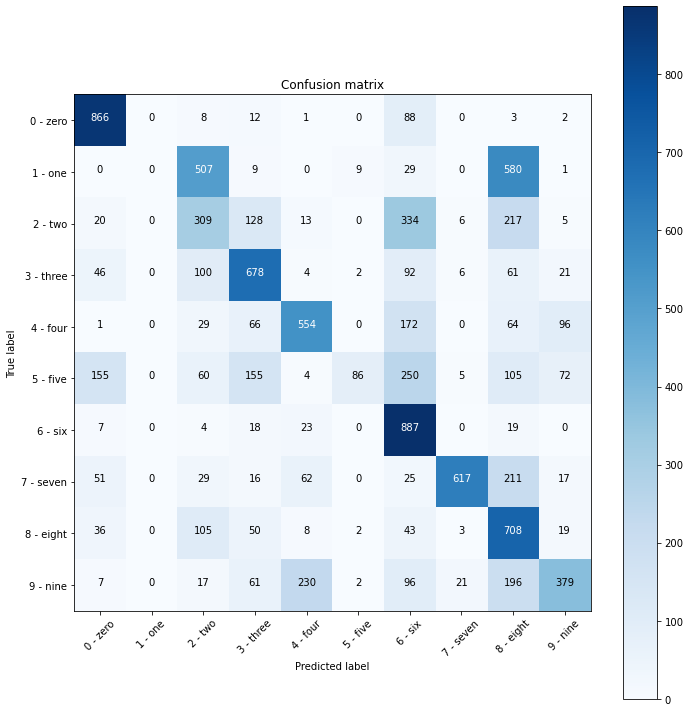

In [42]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cmt, test_data.classes)

<AxesSubplot:>

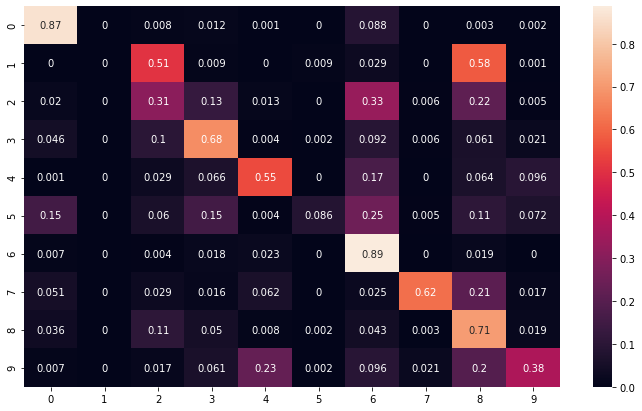

In [43]:
y_pred = []
y_true = []

for inputs, labels in loaders['test']:
        output = cnn(inputs) # Feed Network
#         print("output_BEFORE: ", output)

        output = (torch.max(torch.exp(output[0]), 1)[1]).data.cpu().numpy()
#         print("output_AFTER = ", output)
#         print("len(output) = ", len(output), "\n")
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')

<h2>Plotting Metrics</h2>

NameError: name 'train_acc_data' is not defined

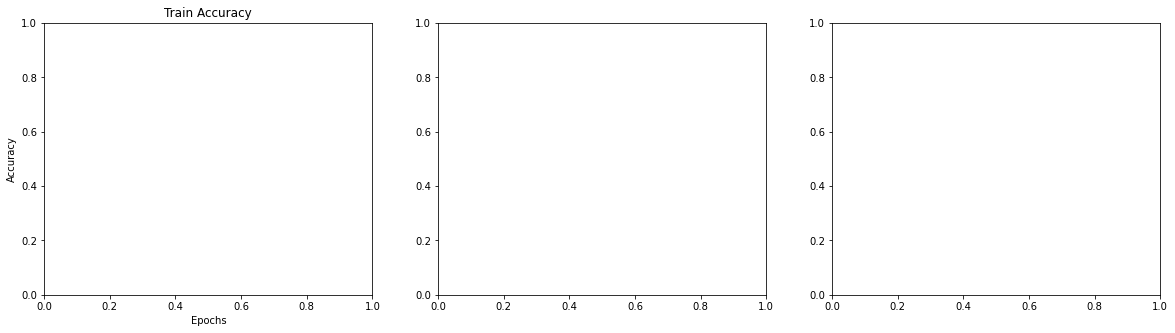

In [44]:
f, axarr = plt.subplots(1,3, figsize=(20, 5))
axarr[0].set_title("Train Accuracy")
axarr[0].set_xlabel("Epochs")
axarr[0].set_ylabel("Accuracy")
axarr[0].plot(train_acc_data)

axarr[1].set_title("Test Accuracy")
axarr[1].set_xlabel("Epochs")
axarr[1].set_ylabel("Accuracy")
axarr[1].plot(test_acc_data)


axarr[2].set_title("Loss")
axarr[2].set_xlabel("Epochs")
axarr[2].set_ylabel("Loss Value")
axarr[2].plot(loss_data)


What's the difference between `torch.save(the_model.state_dict(), PATH)` and `torch.save(model, PATH)`?

In [ ]:
f = "data"
torch.save(cnn, f)

In [ ]:
model = torch.load(f)
model.eval()
model

In [ ]:
f = "data2"
torch.save(cnn.state_dict(), f)
model = torch.load(f)
model

In [ ]:
cnn.train()
len(loaders['train'])

In [ ]:
type(train_data)

In [ ]:
type(resized_28)

<h1>Attempting to resize the dataset when importing with datasets.MNIST</h1>

In [ ]:
# train_data = datasets.MNIST(
#     root = 'data',
#     train = True,                         
#     transform = transforms.Compose([
#                     transforms.ToTensor(),
#                     transforms.Resize(size=14)(train_data.data),
#                     transforms.Normalize(0, 1)
#                 ]), 
#     download = True,            
# )
# test_data = datasets.MNIST(
#     root = 'data', 
#     train = False, 
#     transform = transforms.Compose([
#                     transforms.ToTensor(),
#                     transforms.Resize(size=14)(test_data.data),
#                     transforms.Normalize(0, 1)
#                 ]) 
# )

In [ ]:
train_data.data.shape